In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import json
import re
from shapely.geometry import Point, LineString
from scipy.spatial import distance
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import numpy as np
from operator import itemgetter
import copy
import warnings
warnings.filterwarnings('ignore')

# for plotting legend moving around
from matplotlib.ticker import MaxNLocator
#import community as community_louvain
from networkx.algorithms import community

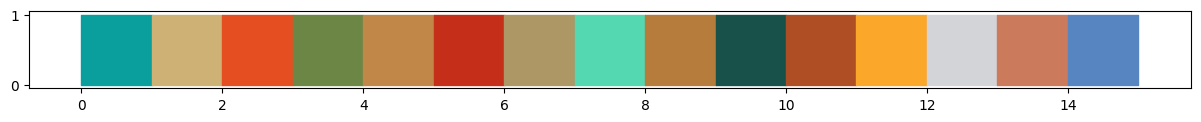

In [2]:
# Now import my favourite colour palette:
asteroid_city_col = ["#0A9F9D", "#CEB175", "#E54E21", "#6C8645", "#C18748", 
                     "#C52E19", "#AC9765", "#54D8B1", "#b67c3b", "#175149", 
                     "#AF4E24", "#FBA72A", "#D3D4D8", "#CB7A5C", "#5785C1"]

# Now let's plot color pallette
plt.figure(figsize=(15, 1))
for i, color in enumerate(asteroid_city_col):
    plt.fill_between([i, i + 1], 0, 1, color=color)

In [3]:
graph_2 = nx.read_graphml('london_test.graph')
# convert str into tuple:
for node in graph_2.nodes():
    graph_2.nodes[node]['coords'] = eval(graph_2.nodes[node]['coords'])



In [10]:
def weighted_global_efficiency_calc(G, weight='weight'):
    # n = len(G)
    # if n <= 1:
    #     return 0
    
    # sum_efficiency = 0.0
    # # for node in G:
    # #     # Get the shortest path lengths from the node to all other nodes, considering the edge weights
    # #     path_lengths = nx.single_source_dijkstra_path_length(G, node, weight=weight)
    # #     # Sum the inverse of these path lengths
    # #     sum_efficiency += sum(1/d for d in path_lengths.values() if d > 0)

    # # The formula for global efficiency
    # return 1/(sum_efficiency * (n * (n - 1)))

    n = len(G)
    if n <= 1:
        return 0
    total_distance_inverse = 0
    for u in G.nodes():
        path_lengths = nx.single_source_dijkstra_path_length(G, u, weight=weight)
        #print(path_lengths)
        total_distance_inverse += sum(1.0 / l for v, l in path_lengths.items() if u != v and l > 0)
        #print(total_distance_inverse)
    return (total_distance_inverse) /(n * (n - 1))


def delta_calc_w(input_graph, weight='weight'):
    """
    Calculate the delta centrality for a weighted network considering the weights on edges.
    
    Parameters:
    - input_graph (nx.Graph): The input graph, which should be a weighted graph.
    - weight (str): The attribute in input_graph that contains the edge weights.
    
    Returns:
    - dict: A dictionary where keys are nodes and values are the delta centrality values.
    """
    
    delta_centrality = {}
    
    # Calculate the original global efficiency considering edge weights
    original_efficiency = weighted_global_efficiency_calc(input_graph, weight=weight)

    for node in input_graph.nodes():
        graph_copy = copy.deepcopy(input_graph)
        graph_copy.remove_node(node)

        # Calculate the efficiency of the graph after removing the node, considering weights
        removed_efficiency = weighted_global_efficiency_calc(graph_copy,weight=weight)

        # Calculate information centrality
        delta_centrality[node] = (original_efficiency - removed_efficiency) / original_efficiency

    return delta_centrality

In [5]:
def calc_w_degree_centrality(G, calc_weight):
    degree = G.degree(weight = calc_weight)
    # Normalize if necessary by the number of nodes minus one
    normalized_degree = {node: deg / (len(G) - 1) for node, deg in degree}
    return normalized_degree

In [6]:
# define a newweight attribute for graph, newweight is total  (1 + (flow/distance))*(deg(node)/ (total_nodes)):s

for u, v, d in graph_2.edges(data=True):
    d['new_weight'] = (np.log(d['length'])/np.log((d['flows']+11)))



In [13]:
weighted_betweenness_centrality = nx.betweenness_centrality(graph_2, weight='new_weight', normalized=True)
weighted_degree_centrality = calc_w_degree_centrality(graph_2, 'new_weight')
weighted_delta_centrality = delta_calc_w(graph_2, 'new_weight')

In [ ]:
# add back to graph
nx.set_node_attributes(graph_2,weighted_betweenness_centrality,'weighted_betweenness_centrality')
# form pandas pd:
df_weighted_bet = pd.DataFrame(index=graph_2.nodes())
df_weighted_bet['weighted_betweenness_centrality'] = pd.Series(nx.get_node_attributes(graph_2, 'weighted_betweenness_centrality'))
df_weighted_bet_sorted = df_weighted_bet.sort_values(["weighted_betweenness_centrality"], ascending=False)
df_weighted_bet_sorted.to_csv('outputs/weighted_betweenness_centrality2.csv')
df_weighted_bet_sorted[0:10]

In [ ]:

# add back to graph
nx.set_node_attributes(graph_2,weighted_degree_centrality,'weighted_degree_centrality')
degree_weighted_sorted = sorted(weighted_degree_centrality.items(), key=lambda x: x[1], reverse=True)

df_weighted_degree = pd.DataFrame(index=graph_2.nodes())
df_weighted_degree['weighted_degree_centrality'] = pd.Series(nx.get_node_attributes(graph_2, 'weighted_degree_centrality'))

degree_weighted_sorted_df = df_weighted_degree.sort_values(["weighted_degree_centrality"], ascending=False)
degree_weighted_sorted_df.to_csv('outputs/weighted_degree_centrality3.csv')

In [ ]:
#weighted_global_efficiency_calc(graph_2, weight='new_weight')

nx.set_node_attributes(graph_2,weighted_delta_centrality,'weighted_delta_centrality')
delta_weighted_sorted = sorted(weighted_delta_centrality.items(), key=lambda x: x[1], reverse=True)

df_weighted_delta= pd.DataFrame(index=graph_2.nodes())
df_weighted_delta['weighted_delta_centrality'] = pd.Series(nx.get_node_attributes(graph_2, 'weighted_delta_centrality'))

delta_weighted_sorted_df = df_weighted_delta.sort_values(["weighted_delta_centrality"], ascending=False)
delta_weighted_sorted_df.to_csv('outputs/weighted_delta_centrality8.csv')

In [8]:
def calculate_critical_threshold(G, weight='weight'):
    """
    Calculate the critical threshold of a network based on the percolation theory.
    This function removes edges from the network starting from the highest weight
    and observes the size of the largest connected component (LCC).

    Parameters:
    - G (nx.Graph): The input graph.
    - weight (str): The edge attribute that represents the weight.

    Returns:
    - float: The critical weight threshold at which the LCC size changes significantly.
    """
    # Sort edges by decreasing weight
    sorted_edges = sorted(G.edges(data=True), key=lambda x: x[2][weight], reverse=True)
    
    # Track the size of the largest connected component
    lcc_sizes = []
    weights = []

    for i, edge in enumerate(sorted_edges):
        # Remove the edge
        G.remove_edge(edge[0], edge[1])
        
        # Find the largest connected component
        lcc = max(nx.connected_components(G), key=len)
        lcc_size = len(lcc)
        lcc_sizes.append(lcc_size)
        weights.append(edge[2][weight])

        # Check for a significant change in the LCC size
        if i > 0 and abs(lcc_sizes[-1] - lcc_sizes[-2]) / lcc_sizes[-2] > 0.05:  # 5% change threshold
            return weights[-1]  # Return the current edge weight as the critical threshold

    # If no significant change was found, return the last weight checked
    return weights[-1] if weights else None

In [9]:
def calculate_modularity(G, weight='weight'):
    """
    Calculate the modularity of the network using the Louvain method.
    
    Parameters:
    - G (nx.Graph): A NetworkX graph.
    - weight (str): The key for edge attribute used to compute the weight.

    Returns:
    - float: The modularity of the partition.
    """
    # Compute the best partition using the Louvain method
    partition = community.greedy_modularity_communities(G, weight=weight)
    
    # Calculate the modularity
    modularity = community.modularity(G,partition,  weight=weight)
    return modularity

In [11]:
def w_non_seq_remove_top_nodes(input_graph, centrality_node_list, n):
    """
    This function removes the top nodes from the graph

    input_graph: networkx graph
    centrality_node_list: centrality measure
    n_top_nodes: number of nodes to remove

    return: results - dict of results for plotting and analysis.
        results = {
            'non_seq_remove': list of nodes removed in non-sequential order
            'global_efficiency_sq': list of global efficiency after each node removal
            'number_of_connected_components_sq': list of number of connected components after each node removal
            }

    """
    #####################################    non-sequential removal  #####################################  
    # init dict to store results
    results = {
    'non_seq_remove': [],
    'global_efficiency_nsq': [],
    'modularity_nsq': []
    }

    # sort nodes by selected centrality measure
    sorted_nodes = sorted(centrality_node_list.items(), key=lambda item: item[1], reverse=True)
    # sequential removal, top n nodes:
    top_n_nodes = [node for node, _ in sorted_nodes[:n]]
    
    # non-seq copy
    non_seq_graph_copy = copy.deepcopy(input_graph)

    # Calculate global efficiency and number of connected components for non-seq removal:
    for node in top_n_nodes:
        # remove top n nodes
        non_seq_graph_copy.remove_node(node)
        #print(f"Node {node} removed")
        
        # Calculate global efficiency
        efficiency = weighted_global_efficiency_calc(non_seq_graph_copy, weight='new_weight')
        #print(f"Efficiency: {efficiency}")

        # Calculate the lcc
        modularity_temp = calculate_modularity(non_seq_graph_copy,'new_weight')
        #print(f"LLC: {lcc}")

        # Append the results
        results['non_seq_remove'].append(node)
        results['global_efficiency_nsq'].append(efficiency)
        results['modularity_nsq'].append(modularity_temp)

    return results
######################################################################################################

In [14]:
non_seq_bet_w = w_non_seq_remove_top_nodes(graph_2, weighted_betweenness_centrality, 100)
non_seq_degree_w = w_non_seq_remove_top_nodes(graph_2, weighted_degree_centrality, 100)
non_seq_delta_w = w_non_seq_remove_top_nodes(graph_2, weighted_delta_centrality, 100)

In [15]:
# non_seq_bet_w to pd.dataframe
df_non_seq_bet_w = pd.DataFrame(non_seq_bet_w)
df_non_seq_bet_w.to_csv('outputs/drop_weighted_nodes/non_seq_bet_w.csv')

df_non_seq_degree_w = pd.DataFrame(non_seq_degree_w)
df_non_seq_degree_w.to_csv('outputs/drop_weighted_nodes/non_seq_degree_w.csv')

df_non_seq_delta_w = pd.DataFrame(non_seq_delta_w)
df_non_seq_delta_w.to_csv('outputs/drop_weighted_nodes/non_seq_delta_w.csv')

In [32]:
def w_seq_remove_top_nodes(input_graph, n, cent_measure):
    """
    This function removes the top nodes from the graph in sequential order

    input_graph: networkx graph
    centrality_node_list: centrality measure

    return: results - dict of results for plotting and analysis.
        results = {
            'seq_remove': list of nodes removed in sequential order
            'global_efficiency_sq': list of global efficiency after each node removal
            'number_of_connected_components_sq': list of number of connected components after each node removal
            }

    """

    ########################################    sequential removal  ######################################

    results = {
        'seq_remove': [],
        'global_efficiency_sq': [],
        'modularity_sq': []
    }

    graph_copy = copy.deepcopy(input_graph)

    for i in range(n):
    # sort nodes by selected centrality measure:
        if cent_measure == 'degree':
            centrality = calc_w_degree_centrality(graph_copy, 'new_weight')

        elif cent_measure == 'between':
            centrality = nx.betweenness_centrality(graph_copy, weight='new_weight', normalized=True)
        
        elif cent_measure == 'delta':
            centrality = delta_calc_w(graph_copy, 'new_weight')
        else:
            print("invalid selection of centrality measure")
        
        # Sort nodes by centrality and select the node with the highest score
        sorted_nodes = sorted(centrality.items(), key=lambda item: item[1], reverse=True)
        node_to_remove = sorted_nodes[0][0]  # Get the node (first element of the tuple)
        print(f"Node {node_to_remove} removed")

        # Log the node and remove it from the graph
        results['seq_remove'].append(node_to_remove)
        graph_copy.remove_node(node_to_remove)

        # Recalculate and store global efficiency and LCC size
        efficiency = weighted_global_efficiency_calc(graph_copy, weight='new_weight')
        modularity_sq = calculate_modularity(graph_copy,'new_weight')
        
        results['global_efficiency_sq'].append(efficiency)
        results['modularity_sq'].append(modularity_sq)

    ######################################################################################################
    return results

In [33]:
seq_bet_w = w_seq_remove_top_nodes(graph_2, 100,'between')


Node Liverpool Street removed
Node Green Park removed
Node King's Cross St. Pancras removed
Node Bank and Monument removed
Node Canada Water removed
Node West Hampstead removed
Node Earl's Court removed
Node Shepherd's Bush removed
Node Stratford removed
Node Oxford Circus removed
Node Queen's Park removed
Node Paddington removed
Node Harrow-on-the-Hill removed
Node West Ham removed
Node Whitechapel removed
Node Embankment removed
Node Blackhorse Road removed
Node Acton Town removed
Node Finsbury Park removed
Node South Kensington removed
Node Canning Town removed
Node Camden Town removed
Node Willesden Junction removed
Node Baker Street removed
Node Hackney Downs removed
Node Romford removed
Node Wandsworth Road removed
Node Stockwell removed
Node Canary Wharf removed
Node North Ealing removed
Node Canonbury removed
Node Hammersmith removed
Node Woodford removed
Node Barking removed
Node Waterloo removed
Node Wembley Park removed
Node Tottenham Court Road removed
Node Poplar removed
N

In [34]:
seq_degree_w = w_seq_remove_top_nodes(graph_2, 100,'degree')


Node Stratford removed
Node Nine Elms removed
Node Baker Street removed
Node Bank and Monument removed
Node Canning Town removed
Node King's Cross St. Pancras removed
Node Wandsworth Road removed
Node Earl's Court removed
Node Oxford Circus removed
Node Turnham Green removed
Node Willesden Junction removed
Node West Ham removed
Node Heathrow Terminals 2 & 3 removed
Node Chalfont & Latimer removed
Node Waterloo removed
Node Blackhorse Road removed
Node Wembley Park removed
Node Surrey Quays removed
Node Green Park removed
Node Poplar removed
Node Seven Sisters removed
Node Whitechapel removed
Node Leicester Square removed
Node Camden Town removed
Node Paddington removed
Node Elephant & Castle removed
Node West Hampstead removed
Node Romford removed
Node Liverpool Street removed
Node Moor Park removed
Node Holborn removed
Node Edmonton Green removed
Node Stockwell removed
Node Canary Wharf removed
Node Notting Hill Gate removed
Node Sydenham removed
Node Gospel Oak removed
Node Woodford 

In [36]:
seq_delta_w = w_seq_remove_top_nodes(graph_2, 100,'delta')

Node Stratford removed
Node Euston removed


KeyboardInterrupt: 

In [35]:
df_seq_bet_w = pd.DataFrame(seq_bet_w)
df_seq_bet_w.to_csv('outputs/drop_weighted_nodes/seq_bet_w.csv')

In [37]:
df_seq_deg_w = pd.DataFrame(seq_degree_w)
df_seq_deg_w.to_csv('outputs/drop_weighted_nodes/seq_degree_w.csv')

In [21]:
df_seq_del_w = pd.DataFrame(seq_delta_w)
df_seq_del_w.to_csv('outputs/drop_weighted_nodes/seq_delta_w.csv')

In [ ]:
# plot
#non_seq_bet_w ['global_efficiency_nsq']
#non_seq_degree_w ['global_efficiency_nsq']
#non_seq_delta_w ['global_efficiency_nsq']


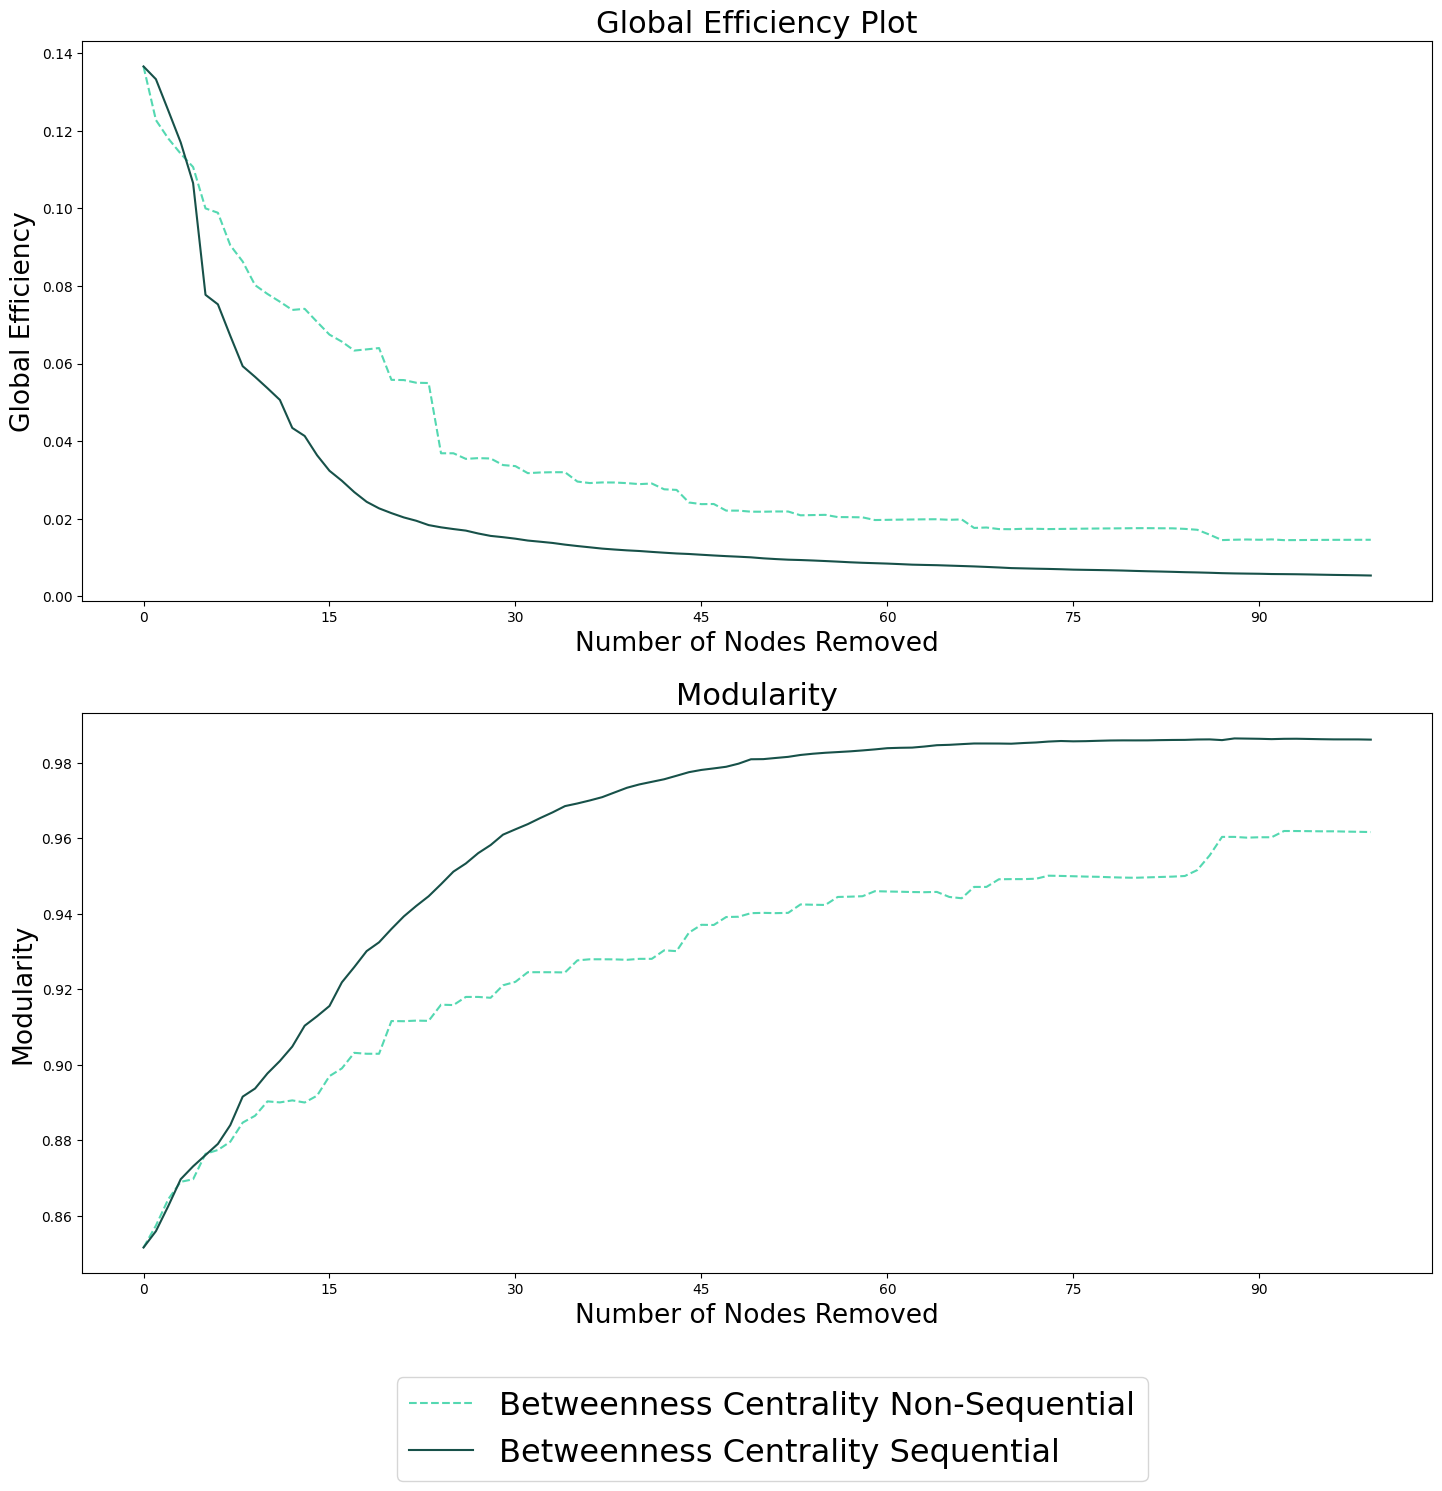

In [53]:
fig, ax = plt.subplots(2, 1, figsize=(20, 16))
plt.subplots_adjust(right=0.8)
#ax[0].plot(non_seq_degree_w['global_efficiency_nsq'], label='Degree Centrality Non-Sequential', color=asteroid_city_col[2],linestyle='--')

#ax[0].plot(seq_degree_w['global_efficiency_sq'], label='Degree Centrality Sequential', color=asteroid_city_col[5])

ax[0].plot(non_seq_bet_w['global_efficiency_nsq'], label='Betweenness Centrality Non-Sequential', color=asteroid_city_col[7],linestyle='--')

ax[0].plot(seq_bet_w['global_efficiency_sq'], label='Betweenness Centrality Sequential', color=asteroid_city_col[9])

#ax[0].plot(non_seq_delta_w['global_efficiency_nsq'], label='Delta Centrality Non-Sequential', color=asteroid_city_col[11],linestyle='--')

#ax[0].plot(seq_delta_w['global_efficiency_sq'], label='Delta Centrality Sequential', color=asteroid_city_col[14])

ax[0].set_title("Global Efficiency Plot", fontsize=22)

ax[0].set_xlabel("Number of Nodes Removed", fontsize=19)

ax[0].set_ylabel("Global Efficiency", fontsize=19)
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
#ax[0].legend(loc='upper right', bbox_to_anchor=(1, 1))

#
#ax[1].plot(non_seq_degree_w['modularity_nsq'], label='Degree Centrality Non-Sequential', color=asteroid_city_col[2],linestyle='--')

#ax[1].plot(seq_degree_w['modularity_sq'], label='Degree Centrality Sequential', color=asteroid_city_col[5])

ax[1].plot(non_seq_bet_w['modularity_nsq'], label='Betweenness Centrality Non-Sequential', color=asteroid_city_col[7],linestyle='--')

ax[1].plot(seq_bet_w['modularity_sq'], label='Betweenness Centrality Sequential', color=asteroid_city_col[9])

#x[1].plot(non_seq_delta_w['modularity_nsq'], label='Delta Centrality Non-Sequential', color=asteroid_city_col[11],linestyle='--')

#ax[1].plot(seq_delta_w['modularity_sq'], label='Delta Centrality Sequential', color=asteroid_city_col[14])

ax[1].set_title("Modularity", fontsize=22)

ax[1].set_xlabel("Number of Nodes Removed", fontsize=19)

ax[1].set_ylabel("Modularity", fontsize=19)
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
#ax[1].legend()


#plt.tight_layout()
#plt.show()
# Place a single legend outside the subplots
handles, labels = [], []
for a in ax:
    for h, l in zip(*a.get_legend_handles_labels()):
        if l not in labels:
            handles.append(h)
            labels.append(l)
# Define font size properties
#prop = {'size': 16}  

# create label
# fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.07, 0.5))
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.47, -0.03), fontsize=23)

plt.tight_layout(rect=[1, 0.43, 1, 1])  # Adjust the right margin to prevent cutting off subplots
plt.show()



In [30]:
seq_degree_w

{'non_seq_remove': ['Stratford',
  'Nine Elms',
  'Kennington',
  'Baker Street',
  'Bank and Monument',
  'Canning Town',
  "King's Cross St. Pancras",
  'West Ham',
  'Wandsworth Road',
  "Earl's Court",
  'Oxford Circus',
  'Liverpool Street',
  'Turnham Green',
  'Waterloo',
  'Willesden Junction',
  'Shadwell',
  'Green Park',
  'Euston',
  'Heathrow Terminals 2 & 3',
  'Chalfont & Latimer',
  'Blackhorse Road',
  'Wembley Park',
  'Acton Town',
  'Surrey Quays',
  'Mile End',
  'Poplar',
  'Seven Sisters',
  'Finchley Road',
  'Whitechapel',
  'Finsbury Park',
  'Battersea Park',
  'Leicester Square',
  'Hammersmith',
  'Battersea Power Station',
  'Camden Town',
  "Shepherd's Bush",
  'Paddington',
  'Elephant & Castle',
  'West Hampstead',
  'Hatton Cross',
  'Piccadilly Circus',
  'Romford',
  'West Brompton',
  'Tottenham Court Road',
  'Moor Park',
  'Holborn',
  'Highbury & Islington',
  'Edmonton Green',
  'Embankment',
  'Stockwell',
  'Canary Wharf',
  'Notting Hill Gate

KeyError: 'global_efficiency_sq'

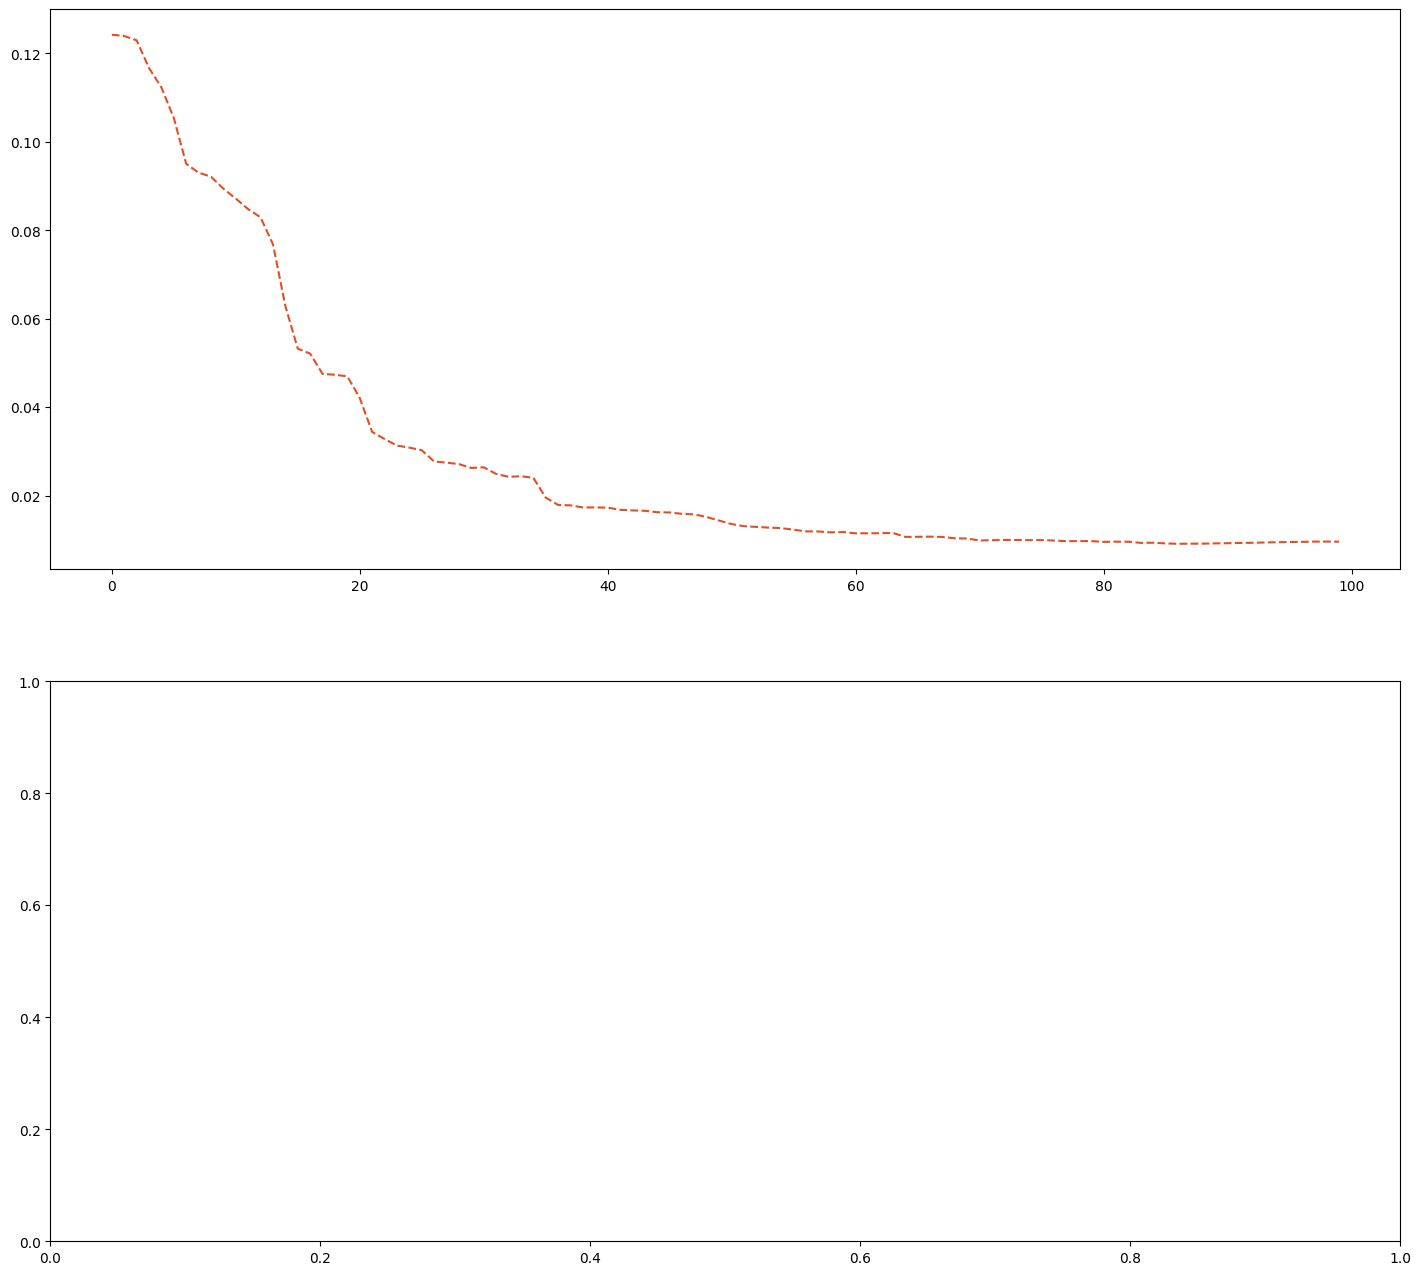

In [29]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(2, 1, figsize=(20, 16))  # Reduced figsize
plt.subplots_adjust(right=0.8)  # Adjust if necessary

# Sample plot details (ensure your data variables are defined)
# ax[0].plot(...)
ax[0].plot(non_seq_degree_w['global_efficiency_nsq'], label='Degree Centrality Non-Sequential', color=asteroid_city_col[2],linestyle='--')

ax[0].plot(seq_degree_w['global_efficiency_sq'], label='Degree Centrality Sequential', color=asteroid_city_col[5])

ax[0].plot(non_seq_bet_w['global_efficiency_nsq'], label='Betweenness Centrality Non-Sequential', color=asteroid_city_col[7],linestyle='--')

ax[0].plot(seq_bet_w['global_efficiency_sq'], label='Betweenness Centrality Sequential', color=asteroid_city_col[9])

ax[0].plot(non_seq_delta_w['global_efficiency_nsq'], label='Delta Centrality Non-Sequential', color=asteroid_city_col[11],linestyle='--')

ax[0].plot(seq_delta_w['global_efficiency_sq'], label='Delta Centrality Sequential', color=asteroid_city_col[14])


ax[0].set_title("Global Efficiency Plot", fontsize=22)
ax[0].set_xlabel("Number of Nodes Removed", fontsize=19)
ax[0].set_ylabel("Global Efficiency", fontsize=19)
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))

ax[1].plot(non_seq_degree_w['modularity_nsq'], label='Degree Centrality Non-Sequential', color=asteroid_city_col[2],linestyle='--')

ax[1].plot(seq_degree_w['modularity_sq'], label='Degree Centrality Sequential', color=asteroid_city_col[5])

ax[1].plot(non_seq_bet_w['modularity_nsq'], label='Betweenness Centrality Non-Sequential', color=asteroid_city_col[7],linestyle='--')

ax[1].plot(seq_bet_w['modularity_sq'], label='Betweenness Centrality Sequential', color=asteroid_city_col[9])

ax[1].plot(non_seq_delta_w['modularity_nsq'], label='Delta Centrality Non-Sequential', color=asteroid_city_col[11],linestyle='--')

ax[1].plot(seq_delta_w['modularity_sq'], label='Delta Centrality Sequential', color=asteroid_city_col[14])

ax[1].set_title("Modularity", fontsize=22)
ax[1].set_xlabel("Number of Nodes Removed", fontsize=19)
ax[1].set_ylabel("Modularity", fontsize=19)
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))

# Handling the legend more effectively
handles, labels = [], []
for a in ax:
    for h, l in zip(*a.get_legend_handles_labels()):
        if l not in labels:
            handles.append(h)
            labels.append(l)

fig.legend(handles, labels, loc='upper center', fontsize=16, ncol=3, bbox_to_anchor=(0.5, -0.05))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the tight_layout parameters
plt.show()


In [ ]:
def percolation_clustering(G, weight='weight'):
    """
    Apply percolation-based hierarchical clustering to a weighted network.

    Parameters:
    - G (nx.Graph): The input weighted graph.
    - weight (str): The edge attribute that contains the weights.

    Returns:
    - dict: A dictionary where keys are threshold levels and values are lists of connected components.
    """

    # Create a sorted list of unique edge weights in descending order
    thresholds = sorted(set(nx.get_edge_attributes(G, weight).values()), reverse=True)

    # Initialize a dictionary to hold the connected components at each threshold
    percolation_clusters = {}

    for threshold in thresholds:
        # Create a copy of the graph
        H = G.copy()
        
        # Remove edges below the current threshold
        for u, v, d in list(H.edges(data=True)):
            if d[weight] < threshold:
                H.remove_edge(u, v)
        
        # Find the connected components at this threshold
        components = [list(c) for c in nx.connected_components(H)]
        
        # Store the components in the dictionary
        percolation_clusters[threshold] = components
    
    return percolation_clusters